In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


In [2]:
lamc=660.
BW = 0.18
par.nonoise=True
sampling=2.0
par.timeframe=1000
par.Nreads = par.timeframe/300
par.PCmode=True
par.lenslet_sampling=1./sampling
# folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_t2000'
folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_noiseless'
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'

try:
    os.makedirs(folder)
    os.makedirs(folder+'/average')
    os.makedirs(folder+'/detector')  
except OSError:
    pass
par.hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
# from crispy.unitTests import testCreateFlatfield
# testCreateFlatfield(par,pixsize=0.1,npix = 512,Nspec=45,pixval = 1.,useQE=True)
# from crispy.IFS import reduceIFSMap
# reduceIFSMap(par,par.unitTestsOutputs+'/flatfield.fits')


### Reconstruct the matched filter library as needed

In [4]:
# from crispy.tools.postprocessing import construct_mflib
# planet_cube_path = folder+'/average'+"/offaxis_planet_red_optext.fits"
# IWA=2.7
# OWA=9
# plcube = Image(planet_cube_path).data
# ydim = plcube.shape[1]
# xdim = plcube.shape[2]
# mask,scratch = bowtie(plcube[0],ydim//2-1,xdim//2,openingAngle=60,
#             clocking=-par.philens*180./np.pi,
#             IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#             OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#             export=None,twomasks=False)    

# construct_mflib(par,planet_cube=planet_cube_path,
#                 threshold=0.2,
#                 lamc=lamc,
#                 BW=BW,
#                 outdir=folder+'/average',
#                 mask=mask,
#                 trim=30,
#                 outname = 'mflib.fits.gz',
#                 order=3)


In [5]:
from crispy.tools.postprocessing import process_SPC_IFS2

signal, noise,noise_no_source,noise_no_rdi,signal_planet = process_SPC_IFS2(par,
                    psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,
                    lamc=lamc,BW=BW,n_ref_star_imgs=30,
                    tel_pupil_area=3.650265060424805*u.m**2,
                    IWA = 2.7,OWA = 9.,
                    forced_inttime_ref = 50., # forced integration time for reference star individual frame
                    pp_fact = 1.00,
                    RDI=True,
                    subtract_dark=False,
                    mflib='',
                    subtract_ref_psf=True,
                    outdir_time_series = folder,
                    outdir_detector=folder+'/detector',
                    outdir_average=folder+'/average',
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=False, # Construct planet and off-axis star files
                    process_detector=False, # Construct IFS detector maps
                    take_averages=False,   # Take averages of these detector maps
                    normalize_cubes=True)

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_ref_star_detector.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_detector.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_noiseless/average/average_target_star_nosource_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/20170525-185543_red_optext.fits
crispy - INFO - Elapsed time: 1.612742s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/20170525-185545_red_optext.fits
crispy - INFO - Elapsed time: 1.258459s
crispy -

In [6]:
signal_planet,signal

(array([  7.91771479e-09,   7.78075849e-09,   7.52009578e-09,
          7.47920583e-09,   7.68143576e-09,   7.78924411e-09,
          7.77037894e-09,   7.71747885e-09,   7.65477654e-09,
          7.58877344e-09,   7.57267412e-09,   7.62499335e-09,
          7.66110228e-09,   7.63341853e-09,   7.54054272e-09,
          7.42890235e-09,   7.38669467e-09,   7.32403209e-09,
          7.06861391e-09]),
 array([  7.87055365e-09,   7.74337656e-09,   7.49711873e-09,
          7.46192360e-09,   7.66713531e-09,   7.77502693e-09,
          7.75779985e-09,   7.70701444e-09,   7.64591646e-09,
          7.58011058e-09,   7.56337437e-09,   7.61519080e-09,
          7.65110206e-09,   7.62369051e-09,   7.53091611e-09,
          7.42014133e-09,   7.38032532e-09,   7.31926880e-09,
          7.06669190e-09]))

In [7]:
noise

[2.0796058638009147e-12,
 2.3600150050197498e-12,
 1.9357916869952853e-12,
 1.6995367081897137e-12,
 1.2527527816829324e-12,
 1.0398046087208427e-12,
 1.019077336710691e-12,
 1.0323567967350804e-12,
 1.0145936195595635e-12,
 9.732320674365558e-13,
 9.7726061071933658e-13,
 1.0859103937601113e-12,
 1.2613148471660113e-12,
 1.4722643348051299e-12,
 1.7951818760206703e-12,
 2.0566629471617049e-12,
 1.7565077455081064e-12,
 1.5037342976764026e-12,
 1.7253858265279835e-12]

In [8]:
noise_no_rdi

[7.0376068511437376e-10,
 4.6526937221036688e-10,
 3.8749979396241775e-10,
 3.6442330425269232e-10,
 3.4153734501603924e-10,
 3.5559005388665713e-10,
 3.8293867530227616e-10,
 3.8616294347005757e-10,
 3.7938285685582172e-10,
 3.8258458377601132e-10,
 4.1539232685798204e-10,
 4.7629648619355954e-10,
 5.413982624596316e-10,
 5.6859432541725671e-10,
 5.7116926467467569e-10,
 5.7458566983459296e-10,
 6.4181921024038971e-10,
 8.0723571108616612e-10,
 1.0008812189104253e-09]

In [9]:
noise_no_source

[2.0796058638009147e-12,
 2.3600150050197498e-12,
 1.9357916869952853e-12,
 1.6995367081897137e-12,
 1.2527527816829324e-12,
 1.0398046087208427e-12,
 1.019077336710691e-12,
 1.0323567967350804e-12,
 1.0145936195595635e-12,
 9.732320674365558e-13,
 9.7726061071933658e-13,
 1.0859103937601113e-12,
 1.2613148471660113e-12,
 1.4722643348051299e-12,
 1.7951818760206703e-12,
 2.0566629471617049e-12,
 1.7565077455081064e-12,
 1.5037342976764026e-12,
 1.7253858265279835e-12]

In [10]:
np.savetxt(folder+"/average/signal.txt",signal)
np.savetxt(folder+"/average/noise.txt",noise)
np.savetxt(folder+"/average/noise_no_rdi.txt",noise_no_rdi)
np.savetxt(folder+"/average/noise_no_source.txt",noise_no_source)


crispy - INFO - Reduced cube will have 19 wavelength bins


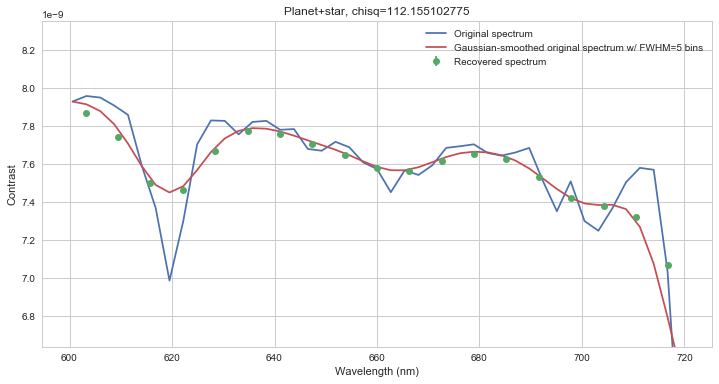

In [17]:
from crispy.tools.postprocessing import SNR_spectrum
from crispy.tools.reduction import calculateWaveList
signal = np.loadtxt(folder+"/average/signal.txt")
noise = np.loadtxt(folder+"/average/noise.txt")
# noise = np.loadtxt(folder+"/average/noise_no_rdi.txt")
# noise = np.loadtxt(folder+"/average/noise_no_source.txt")
lam_midpts,junk = calculateWaveList(par,method='optext')
wavelist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,45)
ratio_out = SNR_spectrum(lam_midpts,signal,noise,lam_contrast=wavelist,outfolder=par.exportDir+"/",
             FWHM=2*45./19.,FWHMdata=2,edges=1,ymargin=0.05)
#np.savetxt(folder+"/average/ratio.txt",ratio_out)



In [12]:
ref_star = fits.getdata(folder+'/average'+'/average_ref_star_detector_red_optext_flatfielded.fits')
target_star_planet = fits.getdata(folder+'/average'+'/average_target_star_detector_red_optext_flatfielded.fits')
target_star = fits.getdata(folder+'/average'+'/average_target_star_nosource_detector_red_optext_flatfielded.fits')
planet = target_star_planet - target_star
planet = fits.getdata(folder+'/average'+'/offaxis_planet_red_optext_flatfielded.fits')
rdi_residual = fits.getdata(folder+'/average'+"/lstsq_residual.fits")
trim = 31


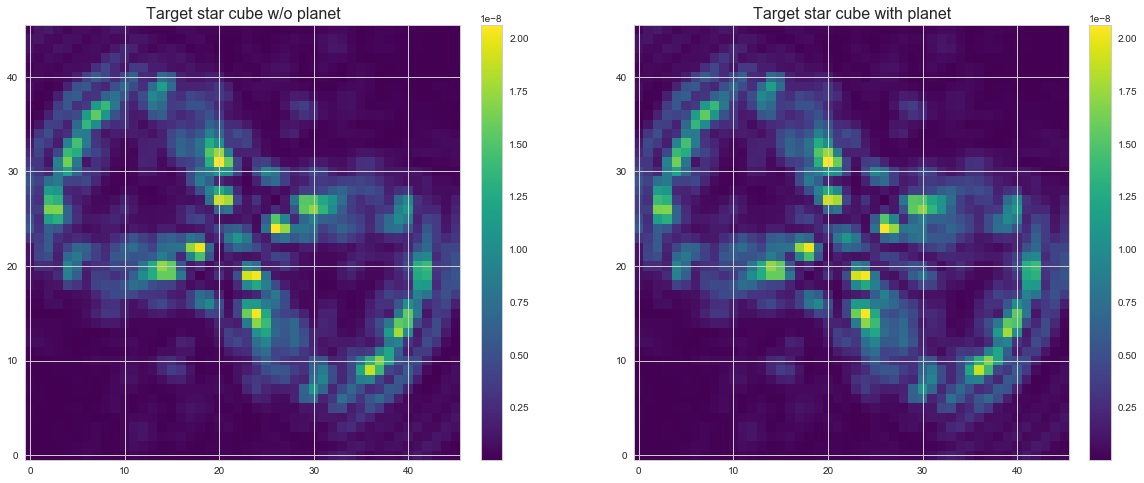

In [13]:
import ipywidgets
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(target_star[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Target star cube w/o planet",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(122)
    plt.imshow(target_star_planet[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Target star cube with planet",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

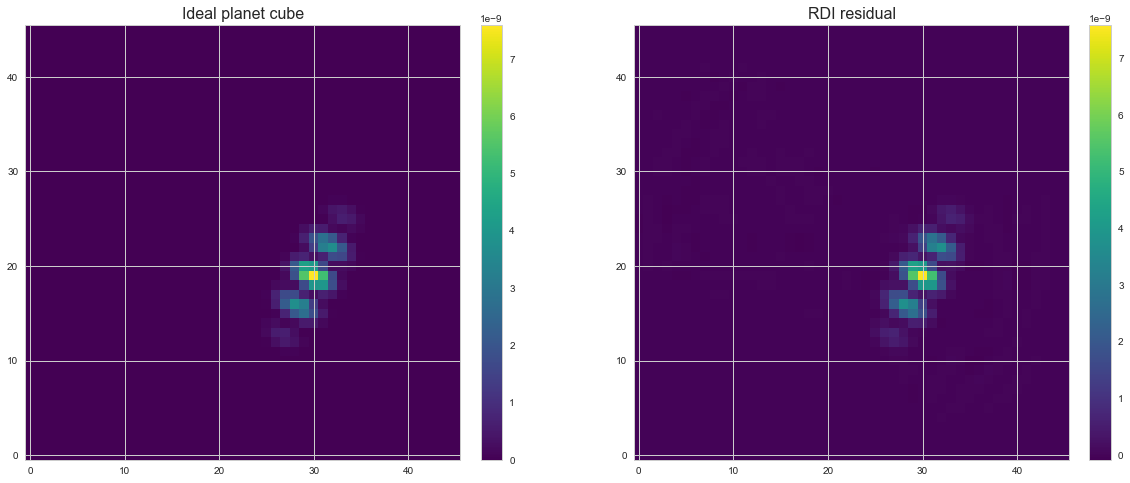

In [14]:
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(planet[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Ideal planet cube",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(122)
    plt.imshow(rdi_residual[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("RDI residual",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

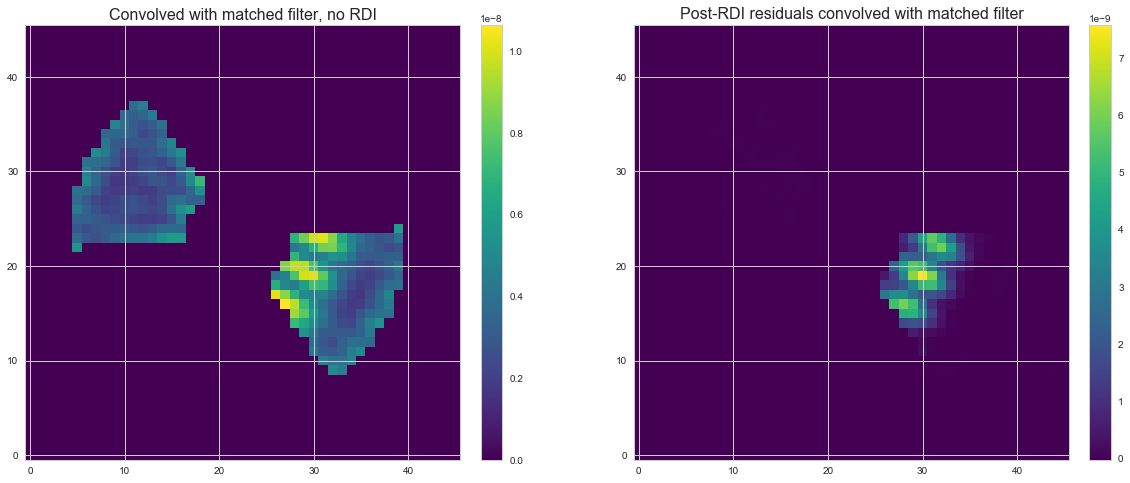

In [15]:
convolved_no_rdi_normalized = fits.getdata(folder+'/average'+'/convolved_no_rdi_normalized.fits')
convolved_normalized = fits.getdata(folder+'/average'+'/convolved_normalized.fits')


def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(convolved_no_rdi_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Convolved with matched filter, no RDI",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(122)
    plt.imshow(convolved_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Post-RDI residuals convolved with matched filter",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

<Container object of 3 artists>

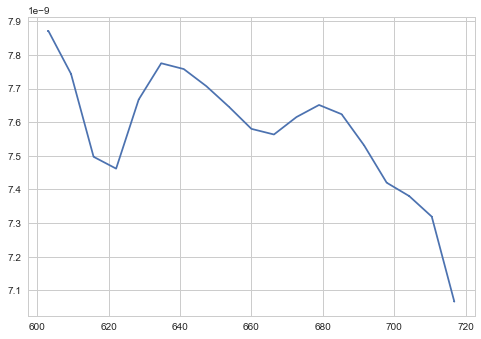

In [16]:
plt.errorbar(lam_midpts,signal,yerr=noise)